## Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import time
import os

## Constants

In [3]:
DARKNET_PATH = 'darknet'
IMG_SIZE = 416

# Read labels that are used on object
labels = open(os.path.join(DARKNET_PATH, "data", "coco.names")).read().splitlines()
# Make random colors with a seed, such that they are the same next time
np.random.seed(0)
colors = np.random.randint(0, 255, size=(len(labels), 3)).tolist()

## Image processing

In [4]:
def img2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
def crop_bounding_box(image, bb):
    x, y, w, h = bb
    return image[y:y+h, x:x+w]

## Plot 

In [6]:
def plot_image(image, title=''):
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [7]:
def draw_bounding_boxes(image_bb, boxes, confidences, class_ids = None):
    for i in range(len(boxes)):
        # Get the box information
        x, y, w, h = boxes[i]
        # Make a rectangle
        color_idx = 0
        if class_ids is not None:
            color_idx = class_ids[i]
        cv2.rectangle(image_bb, (x, y), (x + w, y + h), colors[color_idx], 2)
        # Make and add text
        bb_text = ''
        bb_format = '{}{:.4f}'
        if class_ids is not None:
            bb_text = labels[class_ids[i]]
            bb_format = '{}: {:.4f}'
        text = bb_format.format(bb_text, confidences[i])
        cv2.putText(image_bb, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, colors[color_idx], 2)
    return image_bb

In [8]:
def plot_bounding_boxes(image, bb, color = (255, 0, 0)):
    for (x, y, w, h) in bb:
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
    return image

## Bounding boxes processing

In [9]:
def select_best_bounding_boxes(objects_bounding_boxes):
    final_bb = cv2.dnn.NMSBoxes(objects_bounding_boxes.box, objects_bounding_boxes.confidence, 0.3, 0.3).flatten()
    df_best_bb = objects_bounding_boxes.iloc[final_bb].reset_index(drop=True)
    return df_best_bb

## YOLO

In [10]:
def load_net(model_name = 'yolov3-tiny'):
    # Give the configuration and weight files for the model and load the network.
    net = cv2.dnn.readNetFromDarknet(
        os.path.join(DARKNET_PATH, "cfg", model_name+".cfg"),
        os.path.join(DARKNET_PATH, "cfg", model_name+".weights"), 
    )
    # Determine the output layer, now this piece is not intuitive
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return (net, ln)

In [11]:
def detect_objects(image):
    net, ln = load_net('yolov3')
    # Get the shape
    h, w = image.shape[:2]
    # Load it as a blob and feed it to the network
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (IMG_SIZE, IMG_SIZE), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    # Get the output
    layer_outputs = net.forward(ln)
    end = time.time()
    return layer_outputs

In [12]:
def extract_output(image, layer_outputs):
    # Initialize the lists we need to interpret the results
    boxes = []
    confidences = []
    class_ids = []
    # Get the shape
    h, w = image.shape[:2]
    # Loop over the layers
    for output in layer_outputs:
        # For the layer loop over all detections
        for detection in output:
            # The detection first 4 entries contains the object position and size
            scores = detection[5:]
            # Then it has detection scores - it takes the one with maximal score
            class_id = np.argmax(scores).item()
            # The maximal score is the confidence
            confidence = scores[class_id].item()
            # Ensure we have some reasonable confidence, else ignorre
            if confidence > 0.3:
                # The first four entries have the location and size (center, size)
                # It needs to be scaled up as the result is given in relative size (0.0 to 1.0)
                box = detection[0:4] * np.array([w, h, w, h])
                center_x, center_y, width, height = box.astype(int).tolist()
                # Calculate the upper corner
                x = center_x - width//2
                y = center_y - height//2
                # Add our findings to the lists
                boxes.append([x, y, width, height])
                confidences.append(confidence)
                class_ids.append(class_id)
    return (boxes, confidences, class_ids)

In [13]:
def get_objects_bounding_boxes(image):
    layer_outputs = detect_objects(image)
    boxes, confidences, class_ids = extract_output(image, layer_outputs)
    objects_bounding_boxes = pd.DataFrame({
        'class_id': class_ids,
        'box': boxes,
        'confidence': confidences,
    })
    if len(objects_bounding_boxes) == 0:
        return (objects_bounding_boxes, image)
    objects_bounding_boxes = select_best_bounding_boxes(objects_bounding_boxes)
    image_bb = draw_bounding_boxes(
        image, 
        objects_bounding_boxes.box, 
        objects_bounding_boxes.confidence, 
        objects_bounding_boxes.class_id
    )
    return (objects_bounding_boxes, image_bb)

## cv2 cascade classifier

In [14]:
def create_cv2_cascade_classifier(model_name):
    model_file = cv2.data.haarcascades + model_name + ".xml"
    cv2cc = cv2.CascadeClassifier(model_file)
    return cv2cc

## Analyze body

## Analyze face

In [15]:
def get_face(image):
    haar_cascade_face = create_cv2_cascade_classifier('haarcascade_frontalface_default')
    # haar_cascade_profileface = create_cv2_cascade_classifier('haarcascade_profileface')
    faces = haar_cascade_face.detectMultiScale(image, scaleFactor = 1.2, minNeighbors = 2)
    if len(faces) == 0:
        return None
    # TODO - Select best option
    face_bb = faces[0]
    return face_bb


In [16]:
def analyze_face(face_image):
    haar_cascade_eyes = create_cv2_cascade_classifier('haarcascade_eye') 
    # haar_cascade_nose = create_cv2_cascade_classifier('haarcascade_nose')
    # haar_cascade_mouth = create_cv2_cascade_classifier('haarcascade_mouth')
    haar_cascade_smile = create_cv2_cascade_classifier('haarcascade_smile')

    eyes = haar_cascade_eyes.detectMultiScale(face_image, scaleFactor = 1.1, minNeighbors = 5)
    # TODO - Select two best options
    eyes = eyes[:2]
    plot_bounding_boxes(face_image, eyes, (255, 0, 0))
    
    # noses = haar_cascade_nose.detectMultiScale(face_image, scaleFactor = 1.1, minNeighbors = 5)
    # TODO - Select best option
    # noses = noses[0]
    # plot_bounding_boxes(face_image, eyes, (255, 0, 0))

    # mouths = haar_cascade_mouth.detectMultiScale(face_image, scaleFactor = 1.1, minNeighbors = 5)
    # TODO - Select best option
    # mouths = mouths[0]
    # for (ex, ey, ew, eh) in mouths:
        # cv2.rectangle(face_image, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 3)
        # smiles = haar_cascade_smile.detectMultiScale(face_image, scaleFactor = 1.1, minNeighbors = 5)
        # plot_bounding_boxes(face_image, eyes, (255, 0, 0))
        # TODO - Smiling => Emotions

    return image

## Analyze person

In [17]:
def analyze_person(image):

    # Face
    face_bb = get_face(image)
    if face_bb is not None:
        (x, y, w, h) = face_bb    
        face_image = image[y : y + h, x : x + w]
        face_info = analyze_face(face_image)
    # Gender
    # Age
    # Hair color
    # Hair style
    # Beard
    # Moustache
    # Sunglasses
    # Hat
    # Color skin
    # Emotion
    # Backpack


    # Body


    return face_bb

In [18]:
def get_image_from_dataset(image_file = ''):
    data_path = os.listdir(os.path.join(DARKNET_PATH, 'data'))
    data_path = [x for x in data_path if x.split('.')[-1] in ['png', 'jpg', 'jpeg']]
    if image_file == '':
        image_file = random.choice(data_path)
    image = cv2.imread(os.path.join(DARKNET_PATH, "data", image_file))
    image = img2rgb(image)
    return image

In [19]:
def plot_multiple_objects(image, object_bb):
    bodies_bb = []
    faces_bb = []
    for bb in object_bb:
        body_image = crop_bounding_box(image.copy(), bb)
        face_bb = analyze_person(body_image)
        if face_bb is not None:
            bodies_bb.append(bb)
            faces_bb.append(face_bb)

    n_cols = 3
    n_rows = int(np.ceil(len(faces_bb) / n_cols))
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 25))
    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols+j
            if index < len(faces_bb):
                body_bb = bodies_bb[index]
                face_bb = faces_bb[index]
                face_bb[0] += body_bb[0]
                face_bb[1] += body_bb[1]
                img_aux = plot_bounding_boxes(image.copy(), [body_bb, face_bb])
                if n_rows > 1:
                    axs[i, j].imshow(img_aux)
                else:
                    axs[index].imshow(img_aux)
    fig.tight_layout()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)
    plt.show()            

## Main

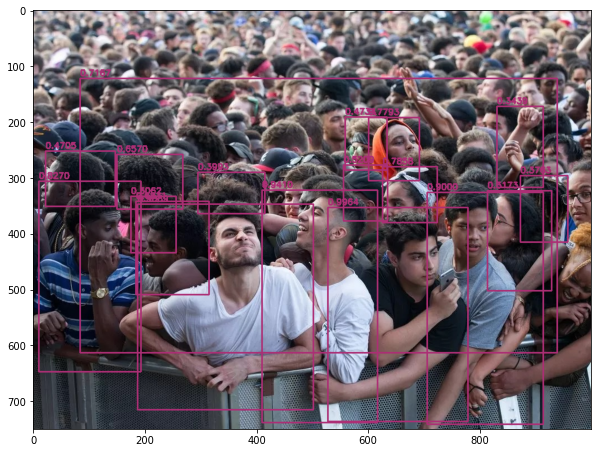

In [20]:
image = get_image_from_dataset()
objects_bounding_boxes, image_bb = get_objects_bounding_boxes(image.copy())

person_bb = objects_bounding_boxes[objects_bounding_boxes['class_id'] == 0]
person_bb = person_bb.drop('class_id', axis=1).reset_index(drop=True)
image_aux = draw_bounding_boxes(image.copy(), person_bb.box, person_bb.confidence)
plot_image(image_aux)

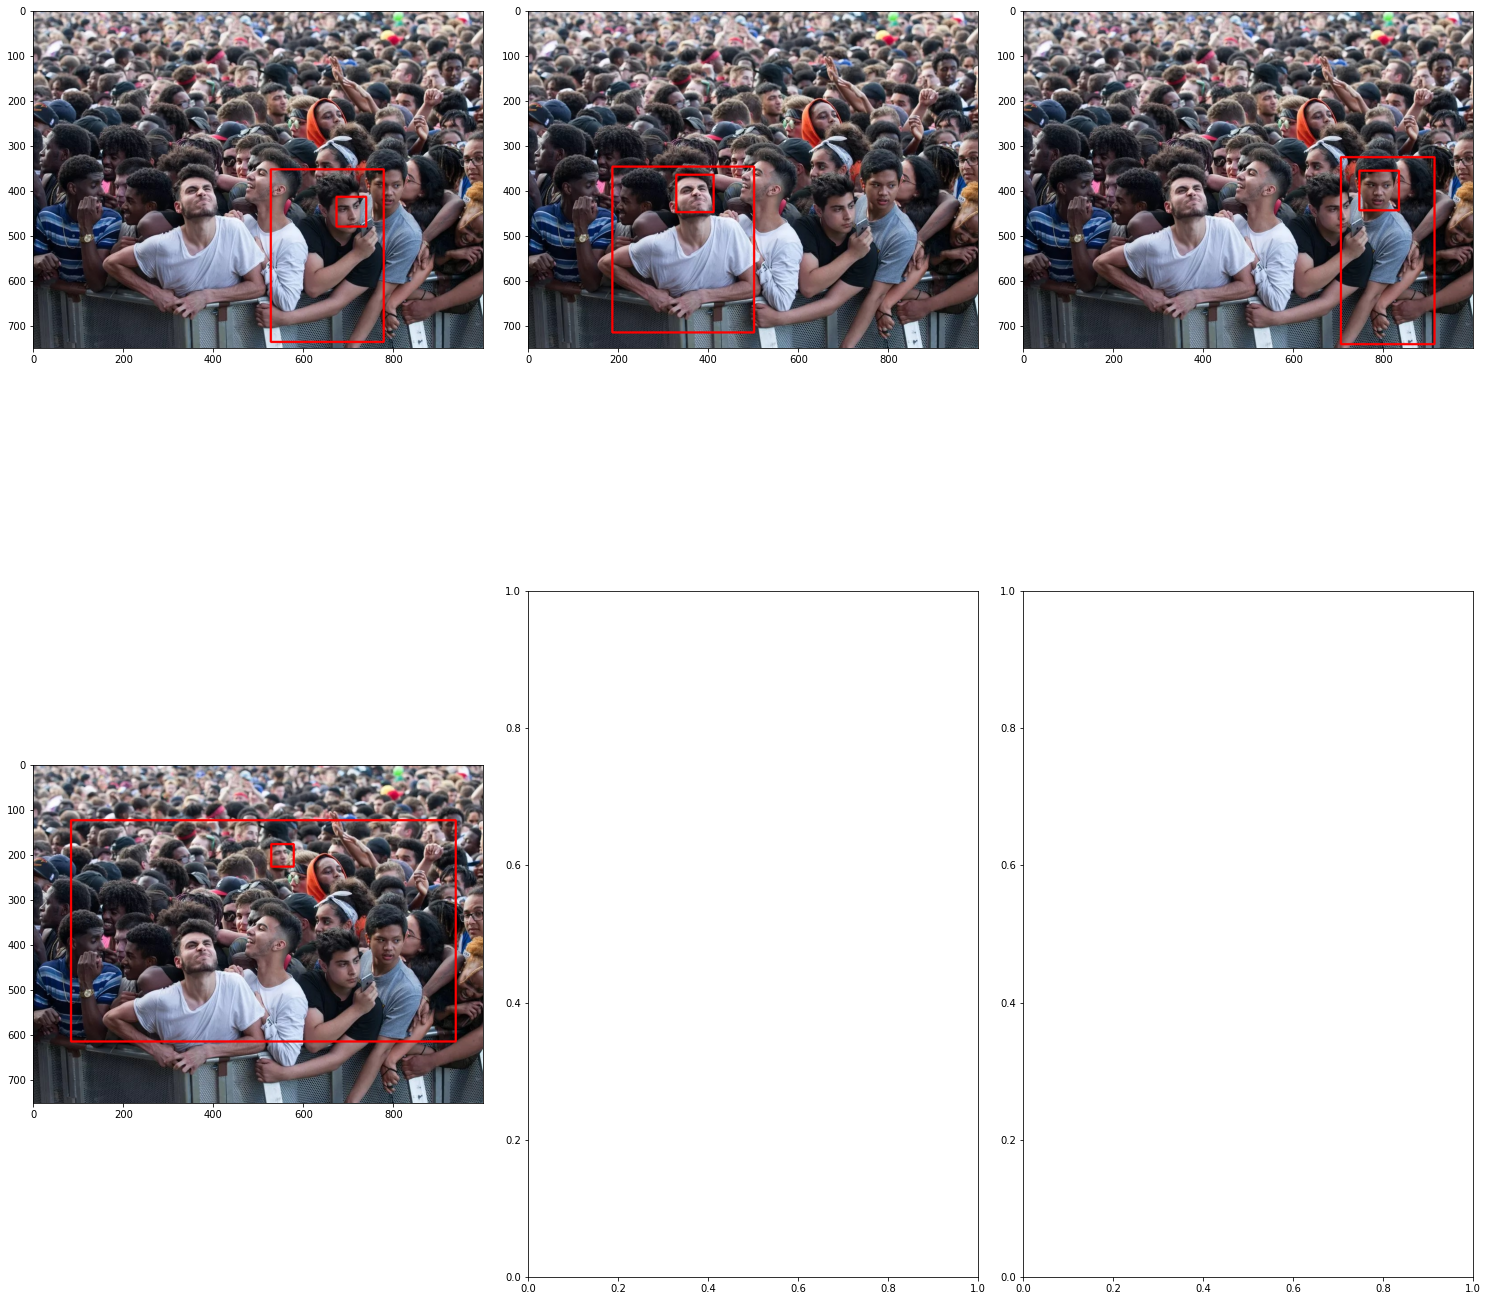

In [21]:
plot_multiple_objects(image.copy(), person_bb['box'])